In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 18, 10

### Stopping to trust Cross validation and keeping an out of sample dataset to validate the results

In [2]:
train = pd.read_csv('src/X_train.csv')

In [3]:
#ID variable
train_ID = train['Id']

In [4]:
#drop the  'Id' colum 
train.drop("Id", axis = 1, inplace = True)

In [5]:
y_train=train["SalePrice"]
#drop the  target colum 
train.drop("SalePrice", axis = 1, inplace = True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size=0.20, random_state=36)

In [9]:
gbm=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=60,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=5,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=1400, presort='auto', random_state=36,
             subsample=1.0, verbose=0, warm_start=False)

In [10]:
gbm.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=60,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=5,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=1400, presort='auto', random_state=36,
             subsample=1.0, verbose=0, warm_start=False)

In [11]:
y_predict=gbm.predict(X_test)

In [12]:
from sklearn.metrics import r2_score

In [13]:
r2_score(y_test,y_predict)

0.89552898231207667

In [14]:
y_test_exp= np.expm1(y_test)
y_predict_exp= np.expm1(y_predict)

In [15]:
r2_score(y_test_exp,y_predict_exp)

0.89987279876670945

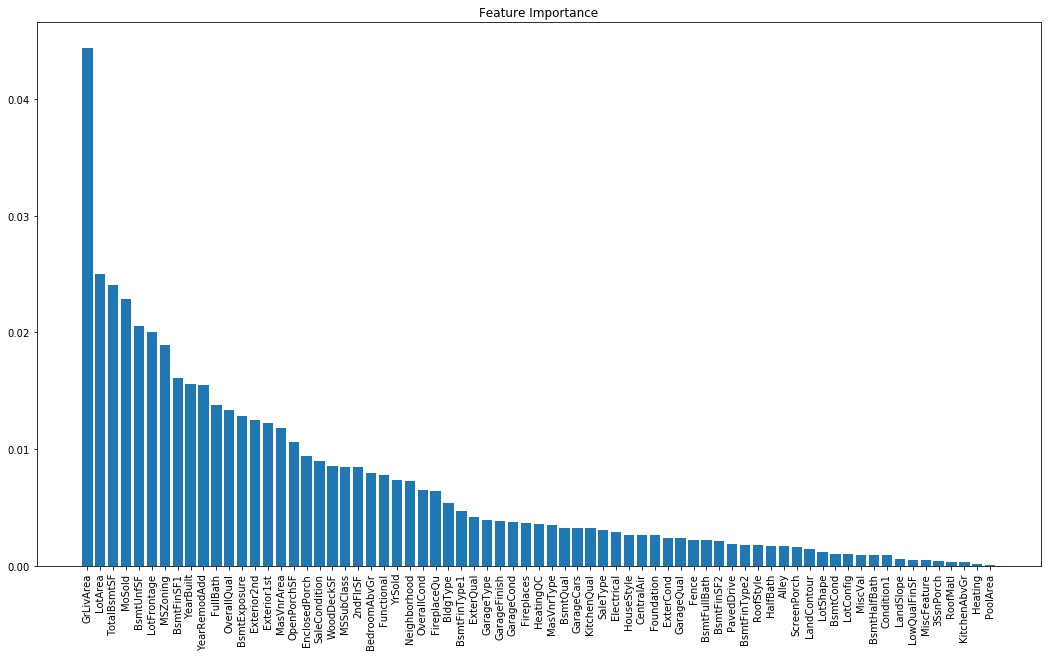

In [32]:
# Plot the feature importances of the forest
importances = gbm.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(train.shape[1]), names, rotation=90)

# Show plot
plt.show()

### Trying to find a better model

In [16]:
# Number of trees in Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Create the random grid
gbm_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [17]:
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = gbm_grid, n_iter = 100, 
                               scoring="neg_mean_squared_error", cv = 4, verbose=2, random_state=36, n_jobs = 3)

In [18]:
# Fit the random search model
gbm_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   46.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  6.0min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=60,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=5,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=1400, presort='auto', random_state=36,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=36, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2)

In [19]:
y_predict=gbm_random.predict(X_test)

In [20]:
r2_score(y_test,y_predict)

0.89532226775676826

### Making a new submission

In [21]:
test = pd.read_csv('src/X_test.csv')

In [22]:
test_ID = test['Id']
test.drop("Id", axis = 1, inplace = True)

In [23]:
test_predict=gbm_random.predict(test)

In [24]:
test_predict= np.expm1(test_predict)

In [25]:
df = pd.DataFrame({'Id':test_ID, 'SalePrice':test_predict})

In [26]:
df.to_csv("output/gbm_after_validation.csv", index=False)

### Plotting the predictions against X_test

In [33]:
y_test_predict=gbm_random.predict(X_test)

In [34]:
y_test_exp= np.expm1(y_test)
y_test_predict_exp= np.expm1(y_test_predict)

In [37]:
len(y_test)

292

In [38]:
len(y_test_predict)

292

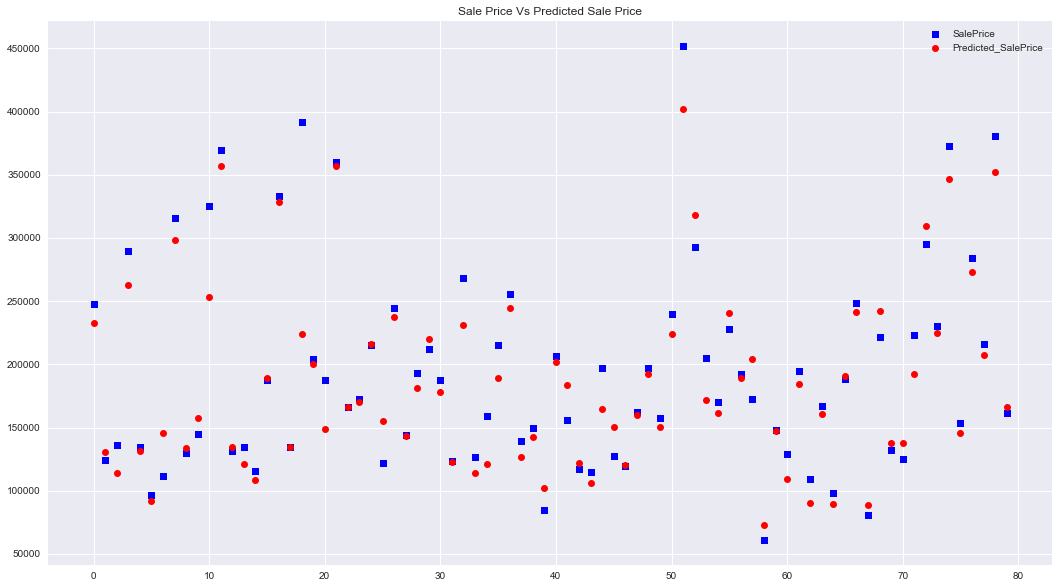

In [60]:
plt.plot(y_test_exp.values[:80], 'bs',y_test_predict_exp[:80],'ro')
plt.legend(["SalePrice","Predicted_SalePrice"])
plt.title("Sale Price Vs Predicted Sale Price")
plt.show()

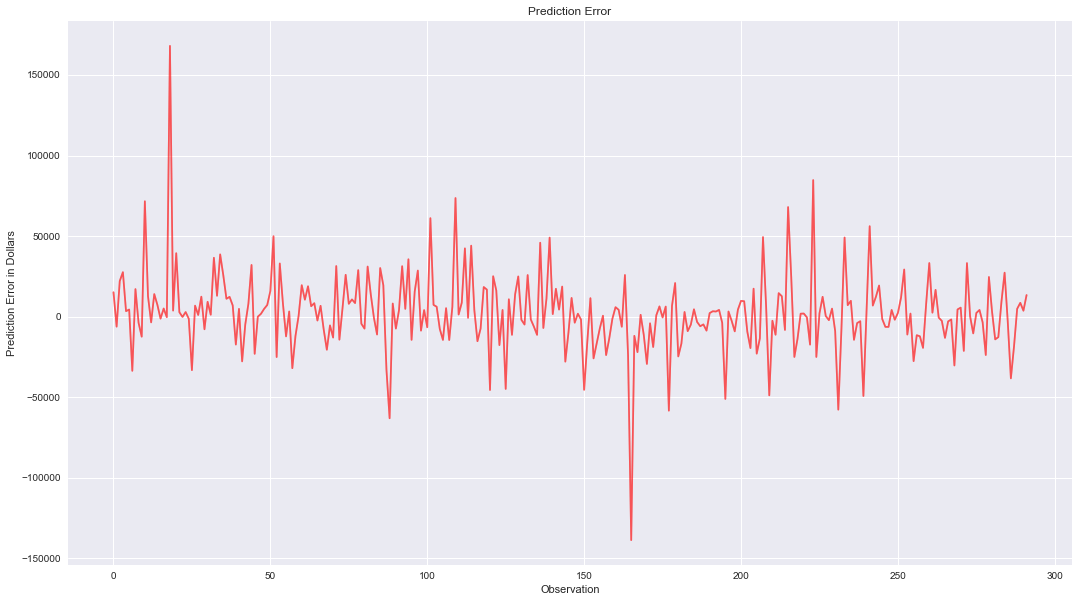

In [71]:
plt.plot(y_test_exp.values-y_test_predict_exp, color="red", alpha=0.4)
plt.title('Prediction Error')
plt.ylabel('Prediction Error in Dollars')
plt.xlabel('Observation')
plt.show()


In [79]:
y_test_exp.mean()

187078.48630136985